# Experimenting with Movie Lens 100k

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../Library')

from Metrics.RMSE import RMSE
from Modules.GaussianDF import GaussianDF as DictionaryFilter
from Modules.NMF import NMF
from Modules.PMF import PMF
from Modules.MVGMF import MVGMF
from Modules.SGDMF import SGDMF

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import tensorflow as tf
import time

2024-07-21 23:09:46.736550: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 23:09:46.764883: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 23:09:47.168033: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Read the dataset
dataset = pd.read_csv('../Data/MovieLens/Small/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,356,137,4.0
1,708,91,2.0
2,411,300,4.0
3,55,59,4.0
4,894,196,3.0


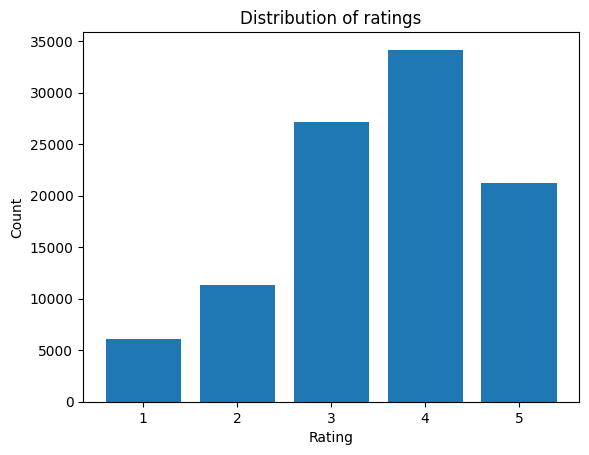

In [3]:
# Plot the distribution of ratings
rating_counts = dataset['Rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [4]:
# Split the train and validation data
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (80000, 3)
Test data shape: (20000, 3)


In [5]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1

In [6]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-21 23:09:47.899904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:09:47.919192: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:09:47.919235: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:09:47.921770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-21 23:09:47.921841: I external/local_xla/xla/stream_executor

## NMF

In [7]:
def fit_nmf(num_movies, num_users, num_factors, init_scale, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a NMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    nmf_train_RMSE = []
    nmf_test_RMSE = []

    # Create the model
    nmf = NMF(m = num_movies, n = num_users, num_factors=num_factors, init_scale=init_scale)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        nmf(train_tensor, train_mask)
        pred = tf.matmul(nmf.C, nmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        nmf_train_RMSE.append(train_RMSE.result().numpy())
        nmf_test_RMSE.append(test_RMSE.result().numpy())
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return nmf_train_RMSE, nmf_test_RMSE, time_taken

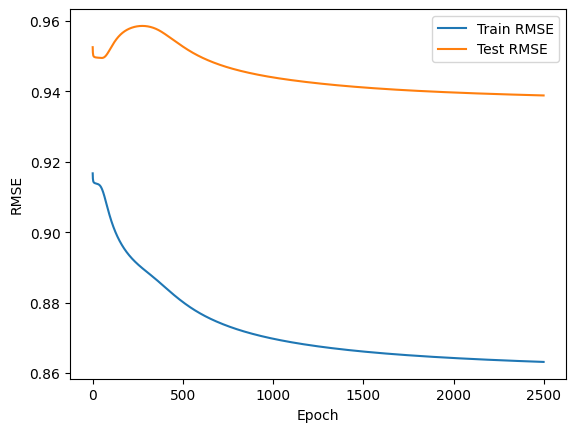

Time taken: 7.82 seconds


In [8]:
# Validate the algorithm
nmf_train_RMSE, nmf_test_RMSE, time_taken = fit_nmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, 2500, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(nmf_train_RMSE, label='Train RMSE')
plt.plot(nmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

## PMF

In [9]:
def fit_pmf(num_movies, num_users, num_factors, init_scale, lambda_C, lambda_X, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a PMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    nmf_train_RMSE = []
    nmf_test_RMSE = []

    # Create the model
    pmf = PMF(m = num_movies, n = num_users, num_factors=num_factors, init_scale=init_scale, lambda_C=lambda_C, lambda_X=lambda_X)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        pmf(train_tensor)
        pred = tf.matmul(pmf.C, pmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        nmf_train_RMSE.append(train_RMSE.result().numpy())
        nmf_test_RMSE.append(test_RMSE.result().numpy())
    
    end_time = time.time()
    time_taken = end_time - start_time
    
    return nmf_train_RMSE, nmf_test_RMSE, time_taken

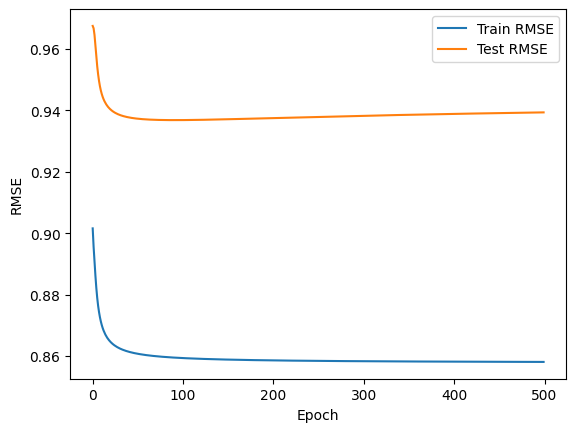

Time taken: 24.57 seconds


In [10]:
# Validate the algorithm
pmf_train_RMSE, pmf_test_RMSE, time_taken = fit_pmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, 0.01, 0.01, 500, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(pmf_train_RMSE, label='Train RMSE')
plt.plot(pmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

## BPMF

array([ 7, 10])

## MVGMF

In [ ]:
def fit_mvgmf(num_movies, num_users, num_factors, k, sigma, init_scale, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a MVGMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    mvgmf_train_RMSE = []
    mvgmf_test_RMSE = []

    # Create the model
    mvgmf = MVGMF(m = num_movies, n = num_users, num_factors=4, k=k, sigma=sigma, init_scale=init_scale)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dense matrices
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    train_mask = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)
    test_mask = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        mvgmf(train_tensor, train_mask)
        pred = tf.matmul(mvgmf.C, mvgmf.X)

        train_RMSE.update_state(train_tensor, pred, train_mask)
        test_RMSE.update_state(test_tensor, pred, test_mask)

        mvgmf_train_RMSE.append(train_RMSE.result().numpy())
        mvgmf_test_RMSE.append(test_RMSE.result().numpy())

    end_time = time.time()
    time_taken = end_time - start_time

    return mvgmf_train_RMSE, mvgmf_test_RMSE, time_taken

2024-07-21 14:08:39.292147: I tensorflow/core/util/cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x556b420982e0


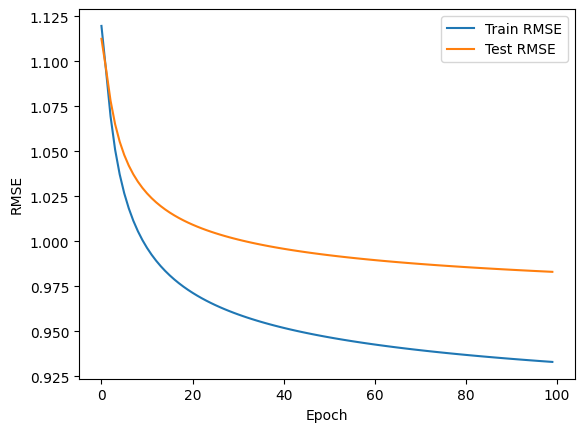

Time taken: 26.19 seconds


In [ ]:
# Validate the algorithm
mvgmf_train_RMSE, mvgmf_test_RMSE, time_taken = fit_mvgmf(NUM_MOVIES, NUM_USERS, 4, 40, 0.2, dataset['Rating'].mean() / 4, 100, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(mvgmf_train_RMSE, label='Train RMSE')
plt.plot(mvgmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

## Dictionary filter

In [ ]:
def create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, test_sparse_tensor):
    """
    Create a TF dataset from the sparse tensors.
    """
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=num_users // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=num_users // batch_size, axis=1)
        for i in range(num_users // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32),
            tf.TensorSpec(shape=[num_movies, None], dtype=tf.float32)
        )
    )

    return dataset

In [ ]:
def fit_df(num_movies, num_users, num_factors, init_scale, train_lambda, batch_size, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits a Dictionary Filter model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    df_train_RMSE = np.zeros(num_epochs)
    df_test_RMSE = np.zeros(num_epochs)

    # Create the model
    model = DictionaryFilter(num_movies, num_factors, init_scale, train_lambda)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dataset
    dataset = create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, test_sparse_tensor)

    # Train the model
    start_time = time.time()
    for epoch in range(num_epochs):
        for train_batch, test_batch in dataset:
            x = model(train_batch)
            train_RMSE.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            test_RMSE.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))

        df_train_RMSE[epoch] = train_RMSE.result().numpy()
        df_test_RMSE[epoch] = test_RMSE.result().numpy()

    end_time = time.time()
    time_taken = end_time - start_time

    return df_train_RMSE, df_test_RMSE, time_taken

2024-07-21 14:09:06.666303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:07.546337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:08.487212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:09.430257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:10.372914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:11.320831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:12.324730: W tensorflow/core/framework/local_rendezvous.cc:404] L

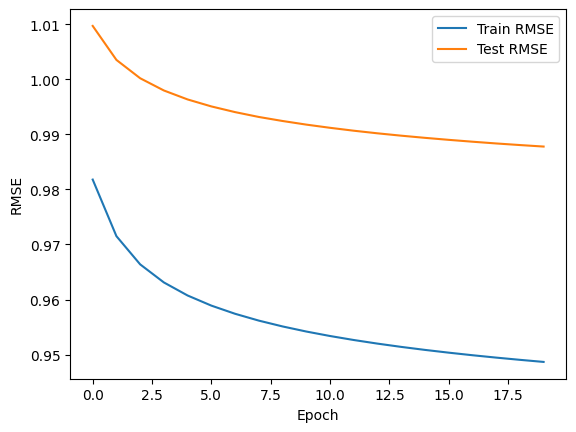

Time taken: 20.11 seconds


In [ ]:
# Validate the algorithm
df_train_RMSE, df_test_RMSE, time_taken = fit_df(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, 2.0, 32, 25, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(df_train_RMSE, label='Train RMSE')
plt.plot(df_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')

## SGDMF

In [ ]:
def fit_sgdmf(num_movies, num_users, num_factors, init_scale, alpha, beta, batch_size, num_epochs, train_sparse_tensor, test_sparse_tensor):
    """
    Fits an SGDMF model to the data and returns the training and testing RMSEs.
    """

    # Initialize variables
    sgdmf_train_RMSE = np.zeros(num_epochs)
    sgdmf_test_RMSE = np.zeros(num_epochs)

    # Create the model
    model = SGDMF(num_movies, num_factors, init_scale, alpha, beta)
    train_RMSE = RMSE()
    test_RMSE = RMSE()

    # Create the dataset
    dataset = create_dataset(num_movies, num_users, batch_size, train_sparse_tensor, test_sparse_tensor)

    # Train the model
    start_time = time.time()
    k = 0
    for epoch in range(num_epochs):
        for train_batch, test_batch in dataset:
            k += 1
            x = model(train_batch, k)
            train_RMSE.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            test_RMSE.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))

        sgdmf_train_RMSE[epoch] = train_RMSE.result().numpy()
        sgdmf_test_RMSE[epoch] = test_RMSE.result().numpy()

    end_time = time.time()
    time_taken = end_time - start_time

    return sgdmf_train_RMSE, sgdmf_test_RMSE, time_taken

2024-07-21 14:09:28.178338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:30.588377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:33.182658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:35.717082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:38.165865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:40.666433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-21 14:09:43.237930: W tensorflow/core/framework/local_rendezvous.cc:404] L

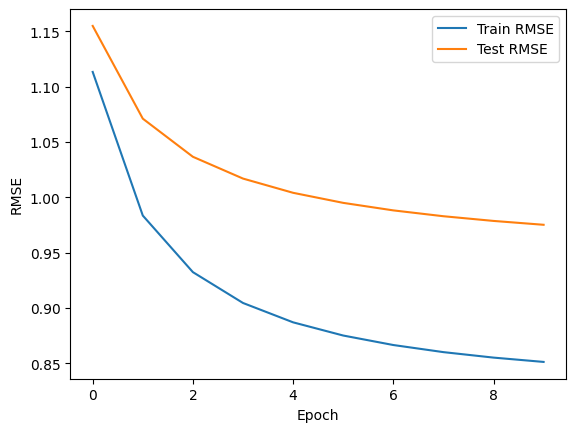

Time taken: 25.13 seconds


In [ ]:
# Validate the algorithm
sgdmf_train_RMSE, sgdmf_test_RMSE, time_taken = fit_sgdmf(NUM_MOVIES, NUM_USERS, 2, dataset['Rating'].mean() / 2, 0.1, 0.0, 32, 10, train_sparse_tensor, test_sparse_tensor)

# Plot the results
plt.plot(sgdmf_train_RMSE, label='Train RMSE')
plt.plot(sgdmf_test_RMSE, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print the time taken
print(f'Time taken: {time_taken:.2f} seconds')